In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import zscore
import numpy as np
import xgboost as xgb
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


- Prvo ćemo izračunati i prikazati osnovne statistike sa pandas library



       Cement (component 1)(kg in a m^3 mixture)  \
count                                1030.000000   
mean                                  281.165631   
std                                   104.507142   
min                                   102.000000   
25%                                   192.375000   
50%                                   272.900000   
75%                                   350.000000   
max                                   540.000000   

       Blast Furnace Slag (component 2)(kg in a m^3 mixture)  \
count                                        1030.000000       
mean                                           73.895485       
std                                            86.279104       
min                                             0.000000       
25%                                             0.000000       
50%                                            22.000000       
75%                                           142.950000       
max                

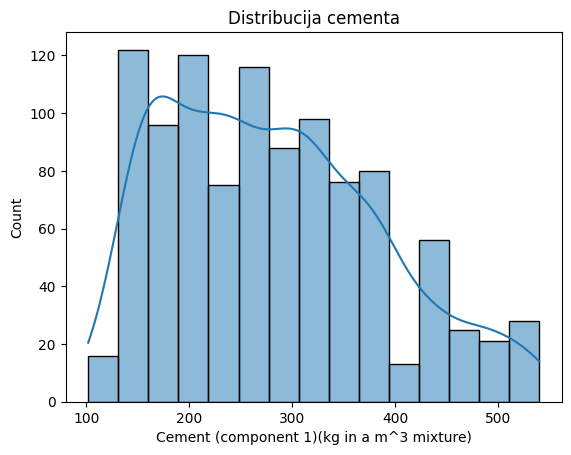

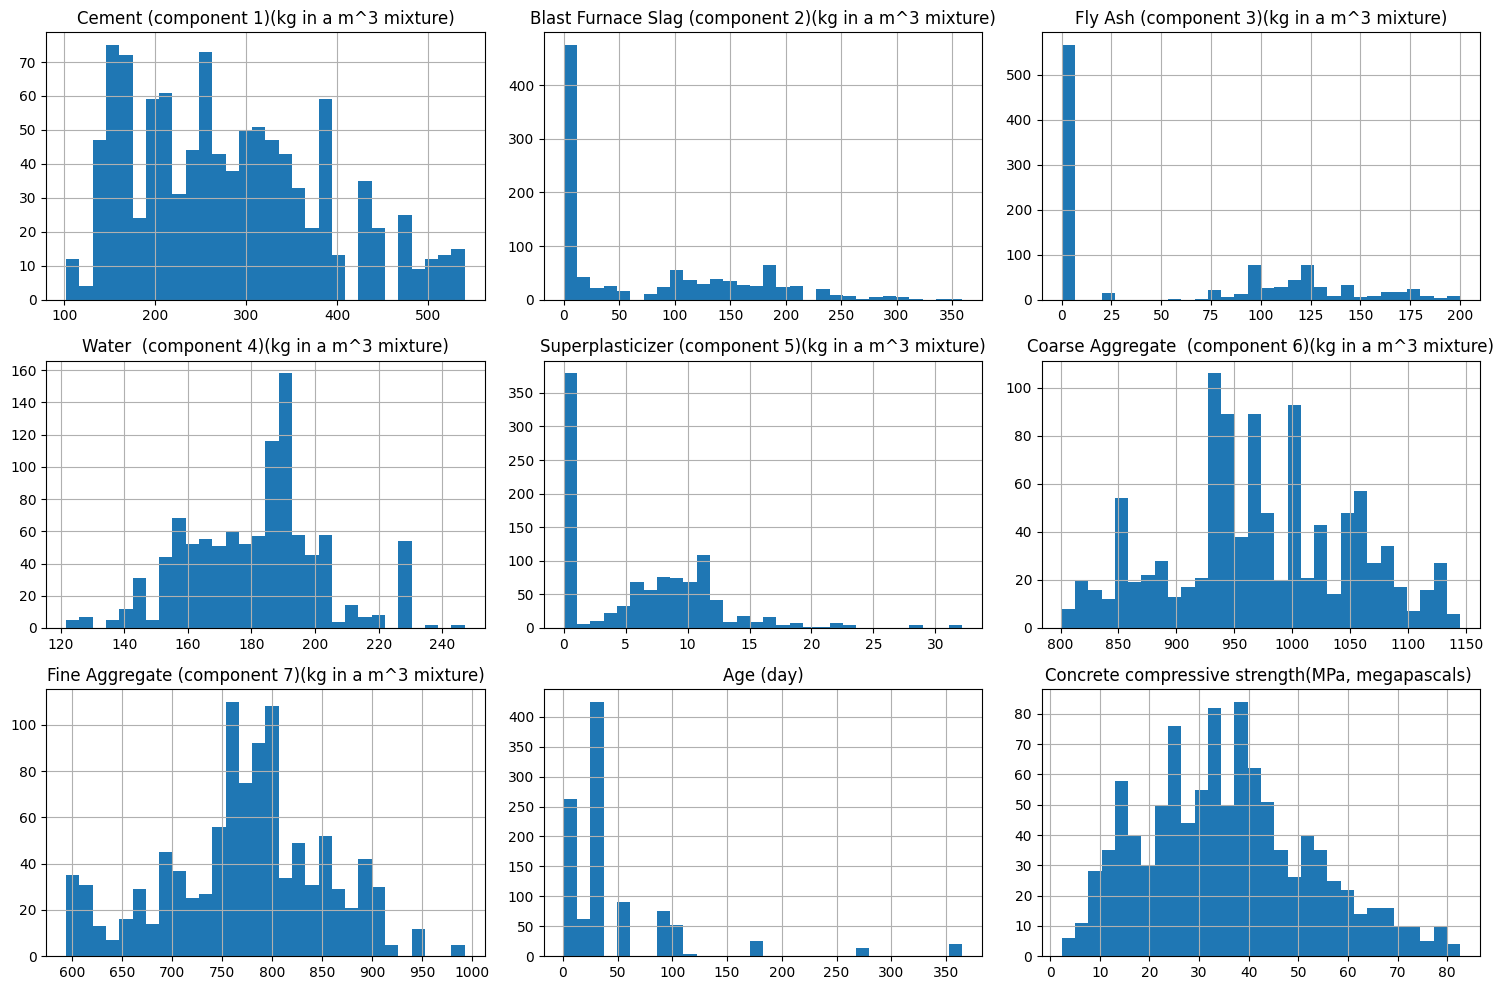

In [4]:
df = pd.read_excel("Concrete_Data.xls")

print(df.describe())

sns.histplot(df['Cement (component 1)(kg in a m^3 mixture)'], kde=True)
plt.title("Distribucija cementa")
plt.show()

df.hist(bins=30, figsize=(15, 10))
plt.tight_layout()
plt.show()

- Ovdje vidimo da određeni atributi kao što su Cement, Water, Fine Aggregate i Coarse Aggregate, imaju dovoljnu varijaciju i podosta su normalne distribucije, te ćemo ih sa sigurnošću koristiti za model (pokoji blago asimetrični)
- ostali atributi (osim Age) su jako asimetrični ili imaju vrijednost blizu 0, što znači da se rijetko koriste, te ih ili nečemo koristiti ili če zahtjevati posebnu obradu

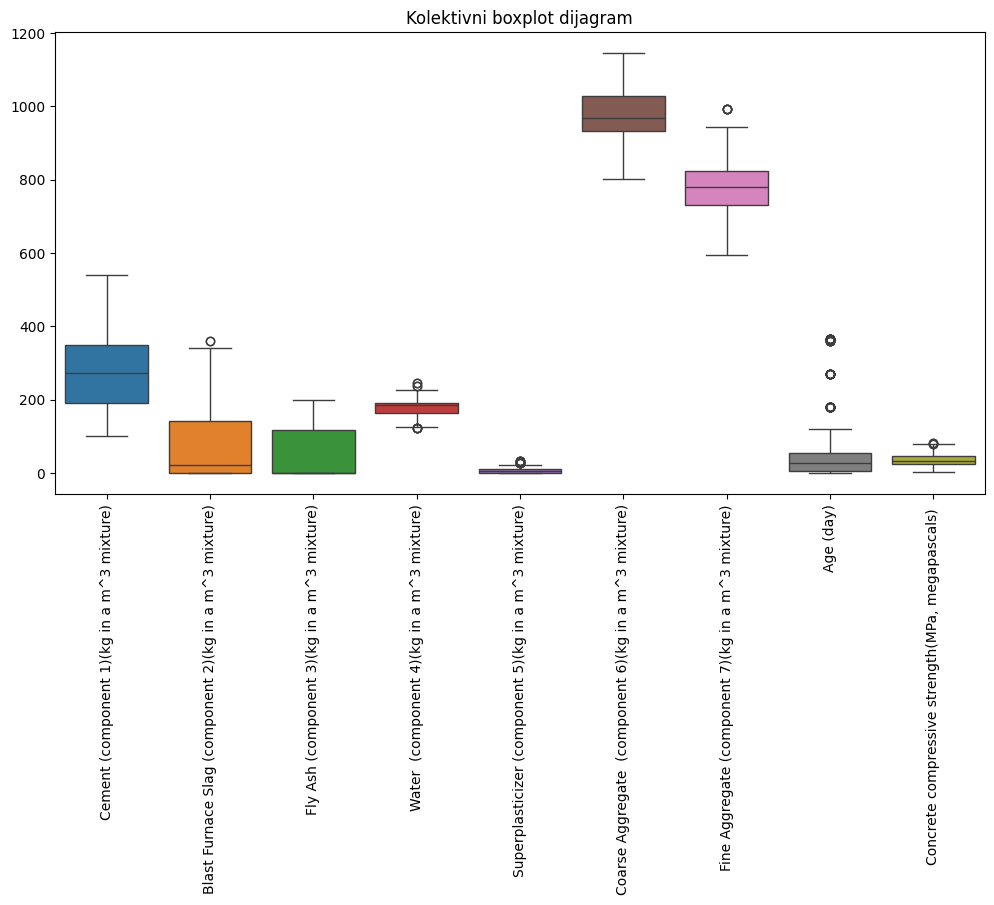

In [5]:
df.isnull().sum()
df.duplicated().sum()
df.corr()

plt.figure(figsize=(12,6))
sns.boxplot(data=df)
plt.xticks(rotation=90)
plt.title("Kolektivni boxplot dijagram")
plt.show()

- ovim boxplotovima smo htjeli provjeritti ekstremne vrijednosti (outliere) našeg skupa podataka
- iz našeg skupa podataka vidimo da u više atributa su prisutni outlieri, kao što su Blast furnace slag, fly ash, superplasticizer, age i strength, što znači da ćemo te atribute trebati dodatno analizirati
- atribut Superplasticizer vidimo da je uglavnom nula, što nam govori da se koristi samo u specifičnim situacijama
- također imamo atribute koji su podosta stabilni te nemaju mnogo outliera, kao što su water i coarse aggregate, što znači da su ti podaci dovoljno konzistentni za naš model

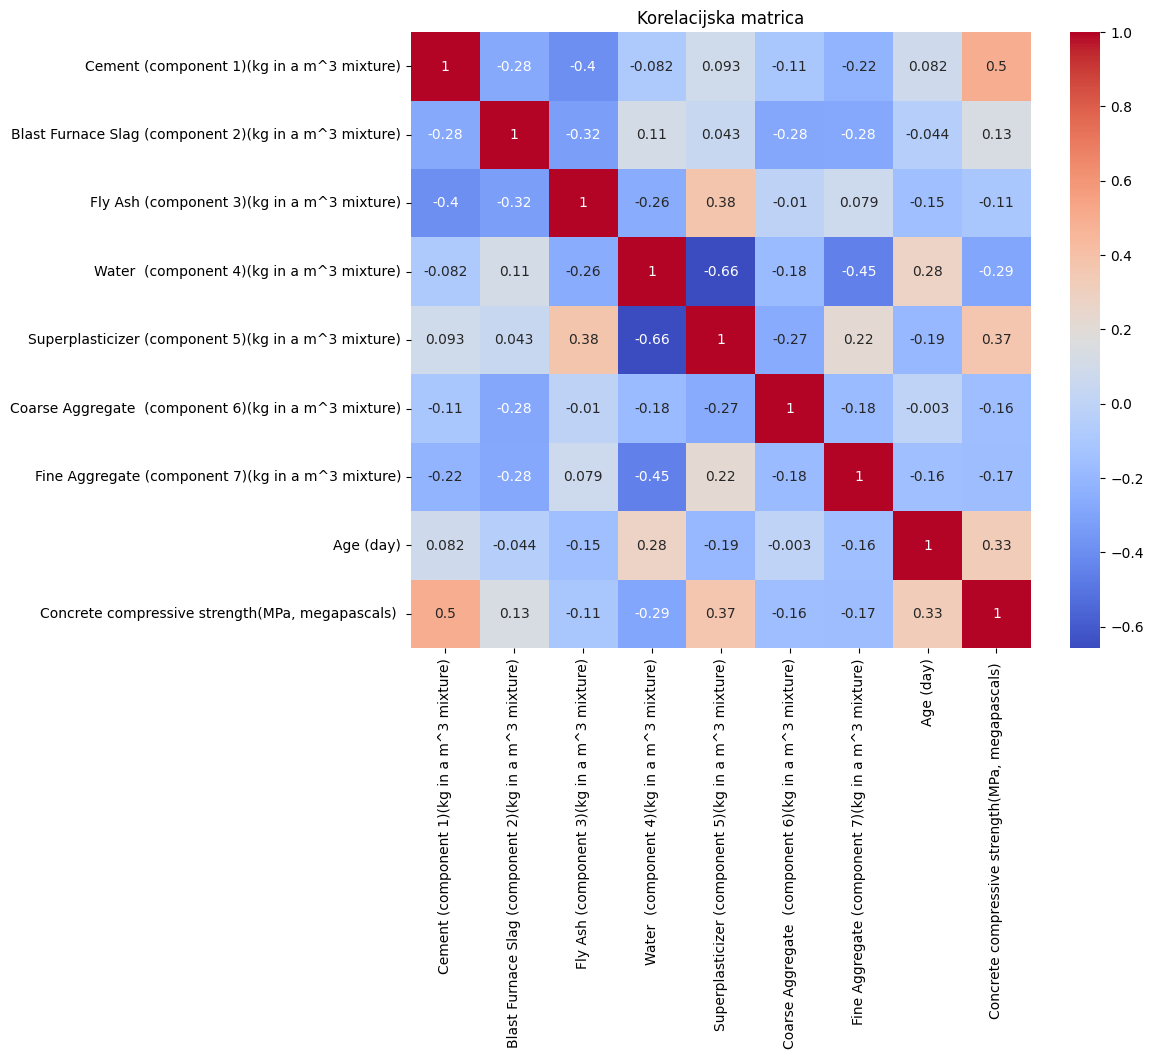

In [6]:
corr_matrix = df.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title("Korelacijska matrica")
plt.show()

- korelacijskom matricom provjeravamo multikolinearnost, tj. varijable koje mogu negativno utjecati na naš model

In [7]:
df = pd.read_excel('Concrete_Data.xls')
missing_values = df.isnull().sum()
print(missing_values)

Cement (component 1)(kg in a m^3 mixture)                0
Blast Furnace Slag (component 2)(kg in a m^3 mixture)    0
Fly Ash (component 3)(kg in a m^3 mixture)               0
Water  (component 4)(kg in a m^3 mixture)                0
Superplasticizer (component 5)(kg in a m^3 mixture)      0
Coarse Aggregate  (component 6)(kg in a m^3 mixture)     0
Fine Aggregate (component 7)(kg in a m^3 mixture)        0
Age (day)                                                0
Concrete compressive strength(MPa, megapascals)          0
dtype: int64


- nedostajućih vrijednosti nemamo


In [8]:
z_scores = np.abs(zscore(df))
outliers = (z_scores > 3).sum(axis=0)
print("Broj outliera po atributima:\n", outliers)

Broj outliera po atributima:
 [ 0  4  0  2 10  0  0 33  0]


- kao što vidimo određene značajke imaju podosta outliera, no za sada ćemo te vrijednosti ostaviti
- ukoliko će kasnije biti potrebna ekstra evaluacija modela i testiranje, outliere ćemo ukloniti

In [9]:
duplicate_rows = df.duplicated().sum()
df = df.drop_duplicates()

- sljedeće izbacujemo duplikate, kako bi naši podaci bili čišći

In [10]:
df['Water_Cement_Ratio'] = df['Water  (component 4)(kg in a m^3 mixture)'] / df['Cement (component 1)(kg in a m^3 mixture)']

In [11]:
print(df[['Water_Cement_Ratio', 'Concrete compressive strength(MPa, megapascals) ']].corr())

                                                  Water_Cement_Ratio  \
Water_Cement_Ratio                                          1.000000   
Concrete compressive strength(MPa, megapascals)            -0.489408   

                                                  Concrete compressive strength(MPa, megapascals)   
Water_Cement_Ratio                                                                       -0.489408  
Concrete compressive strength(MPa, megapascals)                                           1.000000  


- u koraku konstrukcije podataka kreiramo ključan zaključak pod imenom water_cement_ratio koji uvelike utječe na čvrstoću i kvalitetu betona, te ga u sljedećem koraku odmah provjeravamo njegovu korelaciju s ciljnom značajkom
- vrijednost od -0.49 nam govori da je ova korelacija umjerena, ali je dovoljno značajna da nam pokazuje inverznu vezu

In [12]:
bins = [0, 7, 28, 90, 365]
labels = ['<7d', '7-28d', '28-90d', '>90d']
df['Age_Group'] = pd.cut(df['Age (day)'], bins=bins, labels=labels)

- ovdje smo napravili binning za značajku age kako bismo je lakše koristili tijekom kreiranja modela i također rjesili problem outliera

In [13]:
df = pd.get_dummies(df, columns=['Age_Group'], drop_first=True)

- one-hot encoding kako bismo kreirali nove kategoriije koje će uvelike pomoći tijekom modeliranja kasnije

In [14]:
df['Superplasticizer_log'] = np.log1p(df['Superplasticizer (component 5)(kg in a m^3 mixture)'])

- pošto nam značajka superplasticizer ima jaku desnu distribuciju i kako bismo smanjili utjecaj outliera u ovom koraku čemo napraviti log-distribuciju nad tom značajkom i prikazati vizualno razliku između stare i nove verzije značajke

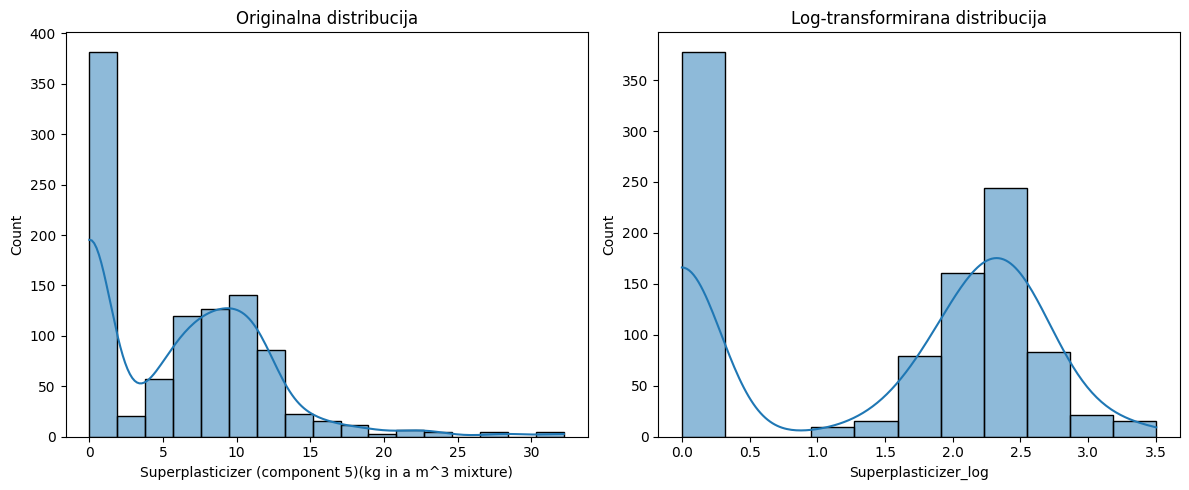

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.histplot(df['Superplasticizer (component 5)(kg in a m^3 mixture)'], kde=True, ax=axes[0])
axes[0].set_title("Originalna distribucija")

sns.histplot(df['Superplasticizer_log'], kde=True, ax=axes[1])
axes[1].set_title("Log-transformirana distribucija")

plt.tight_layout()
plt.show()

In [16]:
df.drop('Superplasticizer (component 5)(kg in a m^3 mixture)', axis=1, inplace=True)
df.rename(columns={'Superplasticizer_log': 'Superplasticizer'}, inplace=True)

- Izbacivanje starog stupca Superplasticizera i zamjena sa novim (pod jednostavnijim imenom)

In [27]:
X = df.drop(columns=['Concrete compressive strength(MPa, megapascals) '])
y = df['Concrete compressive strength(MPa, megapascals) ']
model = xgb.XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42)

kf = KFold(n_splits=5, shuffle=True, random_state=42)
rmse_scores = -cross_val_score(model, X, y, scoring='neg_root_mean_squared_error', cv=kf)
mae_scores = -cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=kf)



print(f"RMSE (mean ± std): {rmse_scores.mean():.2f} ± {rmse_scores.std():.2f}")
print(f"MAE (mean ± std): {mae_scores.mean():.2f} ± {mae_scores.std():.2f}")

model.fit(X, y)

RMSE (mean ± std): 4.51 ± 0.30
MAE (mean ± std): 3.18 ± 0.15


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

- kao što vidimo kod evaluacije nas RMSE je 4.51 +/- 0.30 MPa, što je jako dobro jer se vrijednosti za ovaj skup podataka najčešće kreću između 4 i 7 MPa, što znači da je naš rezultat na donjoj i boljoj strani, tj. veće su pogreške rjeđe
- također možemo vidjeti da je naš MAE 3.18 +/- 0.15 MPa, što nam govori da je prosječno apsolutno odstupanje dosta nisko, jer su normalne granice između 3 i 5 MPa

In [26]:
r2_scores = cross_val_score(model, X, y, scoring='r2', cv=kf)
print(f"R² (mean ± std): {r2_scores.mean():.2f} ± {r2_scores.std():.2f}")

R² (mean ± std): 0.92 ± 0.01
